In [1]:
%pip install datasets
import nltk
from sklearn.metrics import precision_recall_fscore_support
from datasets import load_dataset, load_metric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.7 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

In [3]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

# What is the majority class in our dataset?

In [4]:
# First, we will flatten our BIO labels to make it easier for counting
flatTrainLabels = [item for sublist in train_dataset["ner_tags"] for item in sublist]

# print(flatTrainLabels)

# Count the occurences of each label in our list
majorityClass = max(flatTrainLabels, key = flatTrainLabels.count)

print(majorityClass) # Our majority class is B-O

B-O


# How big is the class imbalance in our dataset?

In [5]:
BOCount = flatTrainLabels.count('B-O')
BLFCount = flatTrainLabels.count('B-LF')
BACCount = flatTrainLabels.count('B-AC')
ILFCount = flatTrainLabels.count('I-LF')

print(f'Amount of B-O: {BOCount}')
print(f'Amount of B-LF: {BLFCount}')
print(f'Amount of B-AC: {BACCount}')
print(f'Amount of I-LF: {ILFCount}')

# We have a massive class imbalance of over 30000 items to B-O!

Amount of B-O: 32971
Amount of B-LF: 1462
Amount of B-AC: 2336
Amount of I-LF: 3231


# Lets see what happens if we undersample the amount of B-O we have in our dataset.

In [6]:
# We get our flattened list of tokens so it is again easier to work with

flatTrainTokens = [item for sublist in train_dataset["tokens"] for item in sublist]

# Fetching our test set of tokens and tags for later

flat_inputs_val = [item for sublist in val_dataset["tokens"] for item in sublist]
flat_labels_val = [item for sublist in val_dataset["ner_tags"] for item in sublist]

# We need to make sure that the amount of tokens and labels are the same so we can undersample using indices!
print(len(flatTrainTokens))
print(len(flatTrainLabels))

40000
40000


Creating a function to undersample the B-O class in our dataset.

In [7]:
import random

random.seed(27)

# Function to undersample a dataset in the form of two seperate flattened 1D arrays
def undersampleFlatDataset(tokenList, tagList, undersampleClass, probability):
  newTokens = []
  newTags = []

  # Iterate through each token and tag
  for token, tag in zip(tokenList, tagList):
    # We do a dice roll if we hit a class that we want to undersample
    if tag == undersampleClass:
      # If the dice roll is less than our defined probability then we add it to the list
      if random.random() < probability:
        newTokens.append(token)
        newTags.append(tag)
    # We just add it back to the list if it is not a undersample class
    else:
      newTokens.append(token)
      newTags.append(tag)

  return newTokens, newTags

In [8]:
underTokens, underTags = undersampleFlatDataset(flatTrainTokens, flatTrainLabels, 'B-O', 0.3)

# underValTokens, underValTags = undersampleFlatDataset(flat_inputs_val, flat_labels_val, 'B-O', 0.3)

Checking our new data

In [9]:
print(len(underTokens))
print(len(underTags))

# We have significantly reduced the amount of data to train with by choosing a lower probability for undersampling

BOCount = underTags.count('B-O')
BLFCount = underTags.count('B-LF')
BACCount = underTags.count('B-AC')
ILFCount = underTags.count('I-LF')

print(f'Amount of B-O: {BOCount}')
print(f'Amount of B-LF: {BLFCount}')
print(f'Amount of B-AC: {BACCount}')
print(f'Amount of I-LF: {ILFCount}')

16710
16710
Amount of B-O: 9681
Amount of B-LF: 1462
Amount of B-AC: 2336
Amount of I-LF: 3231


# We will create a SVM to test training with our undersampled data
We need to embed our tokens first, we will use TFIDF for this...

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

trainInputs = tfidf.fit_transform(underTokens)
valInputs = tfidf.transform(flat_inputs_val)

# Confirm both sets of inputs are of the same dimension
print(trainInputs.shape)
print(valInputs.shape)

(16710, 5275)
(5000, 5275)


We also need to convert our class labels to numeric for use with SVM...

In [11]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

trainConvertedLabels = []
for sample in underTags:
    trainConvertedLabels.append(label_encoding.get(sample))

print(len(trainConvertedLabels))

valConvertedLabels = []
for sample in flat_labels_val:
    valConvertedLabels.append(label_encoding.get(sample))

print(len(valConvertedLabels))

16710
5000


Training the SVM

In [12]:
from sklearn import svm

svmModel = svm.LinearSVC()

svmModel.fit(trainInputs, trainConvertedLabels)

LinearSVC()

Predicting with the trained SVM

In [13]:
from sklearn.metrics import classification_report

preds = svmModel.predict(valInputs)

print(classification_report(valConvertedLabels, preds))

# We can see that each class other than 0 gets a small boost to the F1 Score compared to without undersample (see experiment set 3)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      4261
           1       0.81      0.43      0.56       263
           2       0.40      0.41      0.40       149
           3       0.37      0.43      0.39       327

    accuracy                           0.85      5000
   macro avg       0.62      0.55      0.57      5000
weighted avg       0.85      0.85      0.85      5000



Getting the Confusion Matrix

[[3935   23   78  225]
 [ 148  113    0    2]
 [  73    3   61   12]
 [ 173    0   15  139]]


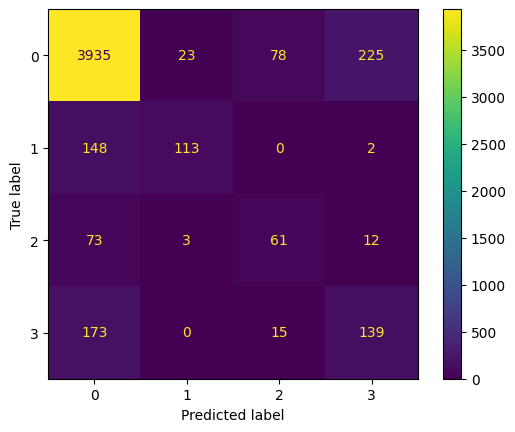

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(valConvertedLabels, preds)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

# What happens if we convert all the tokens to lowercase?
We want to make sure that instances of the same word should be treated the same for training a model, for example words like Because and because would be treated differently but lexically are the same.

In [116]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

flatTrainTokens = [item for sublist in train_dataset["tokens"] for item in sublist]
flatTrainLabels = [item for sublist in train_dataset["ner_tags"] for item in sublist]

flat_inputs_val = [item for sublist in val_dataset["tokens"] for item in sublist]
flat_labels_val = [item for sublist in val_dataset["ner_tags"] for item in sublist]

Converting our train and validation tokens to lowercase

In [119]:
lowerTrainTokens = [item.lower() for item in flatTrainTokens]
lowerValTokens = [item.lower() for item in flat_inputs_val]

print(lowerTrainTokens)
print(lowerValTokens)

['for', 'this', 'purpose', 'the', 'gothenburg', 'young', 'persons', 'empowerment', 'scale', '(', 'gypes', ')', 'was', 'developed', '.', 'the', 'following', 'physiological', 'traits', 'were', 'measured', ':', 'stomatal', 'conductance', '(', 'gs', ',', 'mol', 'h2o', 'm-2', 's-1', ')', ',', 'transpiration', 'rate', '(', 'e', ',', 'mmol', 'h2o', 'm-2', 's-1', ')', ',', 'net', 'photosynthetic', 'rate', '(', 'pn', ',', 'μmol', 'm-2', 's-1', ')', 'and', 'intercellular', 'co2', 'concentration', 'co2', '(', 'ci', ',', 'μmol', 'm-2', 's-1', ')', '.', 'minor', 'h', 'antigen', 'alloimmune', 'responses', 'readily', 'occur', 'in', 'the', 'setting', 'of', 'human', 'leukocyte', 'antigen', '(', 'hla)–matched', 'allogeneic', 'solid', 'organ', 'and', 'stem', 'cell', 'transplantation', '(', 'sct', ')', '[', '3,4', ']', '.', 'epi', '=', 'echo', 'planar', 'imaging', '.', 'furthermore', ',', 'enos', '-', 'derived', 'no', 's', '-', 'nitrosylated', 'β', '-', 'actin', 'on', 'cys374', 'and', 'impaired', 'actin',

Embedding labels and tokens for SVM..

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

trainInputs = tfidf.fit_transform(lowerTrainTokens)
valInputs = tfidf.transform(lowerValTokens)

# Confirm both sets of inputs are of the same dimension
print(trainInputs.shape)
print(valInputs.shape)

(40000, 7869)
(5000, 7869)


In [122]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

trainConvertedLabels = []
for sample in flatTrainLabels:
    trainConvertedLabels.append(label_encoding.get(sample))

print(len(trainConvertedLabels))

valConvertedLabels = []
for sample in flat_labels_val:
    valConvertedLabels.append(label_encoding.get(sample))

print(len(valConvertedLabels))

40000
5000


In [123]:
from sklearn import svm

svmModel = svm.LinearSVC()

svmModel.fit(trainInputs, trainConvertedLabels)

LinearSVC()

In [124]:
from sklearn.metrics import classification_report

preds = svmModel.predict(valInputs)

print(classification_report(valConvertedLabels, preds))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4261
           1       0.85      0.39      0.54       263
           2       0.59      0.28      0.38       149
           3       0.49      0.25      0.33       327

    accuracy                           0.87      5000
   macro avg       0.71      0.47      0.54      5000
weighted avg       0.86      0.87      0.85      5000



[[4147   15   23   76]
 [ 158  103    0    2]
 [  98    3   41    7]
 [ 240    0    5   82]]


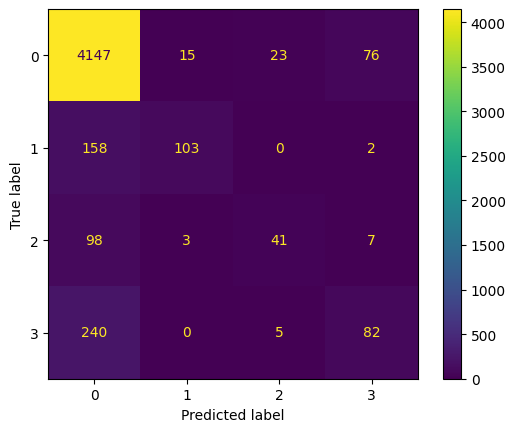

In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(valConvertedLabels, preds)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

# What happens if we try to oversample the dataset?

In [35]:
# Regenerate the dataset
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

flatTrainTokens = [item for sublist in train_dataset["tokens"] for item in sublist]
flatTrainLabels = [item for sublist in train_dataset["ner_tags"] for item in sublist]

flat_inputs_val = [item for sublist in val_dataset["tokens"] for item in sublist]
flat_labels_val = [item for sublist in val_dataset["ner_tags"] for item in sublist]

One simple way to oversample is to duplicate entries of the minority class, we can create a function to do this

In [38]:
import random

# In theory we can at maximum only double our minority classes, but we can re-run the function
def oversampleFlatDataset(tokenList, tagList, oversampleClass, probability, epochs = 1):
  newTokens = []
  newTags = []

  for epoch in range(epochs):
    # Iterate through the tags and tokens
    for token, tag in zip(tokenList, tagList):

      if tag == oversampleClass:
        # Dice roll to see if we duplicate the item
        if random.random() < probability:
          # We duplicate the tokens and the tags
          newTokens.append(token)
          newTokens.append(token)

          newTags.append(tag)
          newTags.append(tag)

      # If its not the target class we add it back normally
      else:
        newTokens.append(token)
        newTags.append(tag)

  return newTokens, newTags

In [46]:
oversampleTrainTokens, oversampleTrainLabels = oversampleFlatDataset(flatTrainTokens, flatTrainLabels, 'B-LF', 0.7)

oversampleTrainTokens, oversampleTrainLabels = oversampleFlatDataset(oversampleTrainTokens, oversampleTrainLabels, 'B-AC', 0.7)

oversampleTrainTokens, oversampleTrainLabels = oversampleFlatDataset(oversampleTrainTokens, oversampleTrainLabels, 'I-LF', 0.7)

Checking our new label counts along with a sanity check for good measure

In [47]:
print(len(oversampleTrainTokens))
print(len(oversampleTrainLabels))

dataset2Count = oversampleTrainLabels

# We have significantly reduced the amount of data to train with by choosing a lower probability for undersampling

BOCount = dataset2Count.count('B-O')
BLFCount = dataset2Count.count('B-LF')
BACCount = dataset2Count.count('B-AC')
ILFCount = dataset2Count.count('I-LF')

# We can see that we have artificially boosted the amount of data we have for our minority classes
print(f'Amount of B-O: {BOCount}')
print(f'Amount of B-LF: {BLFCount}')
print(f'Amount of B-AC: {BACCount}')
print(f'Amount of I-LF: {ILFCount}')

42755
42755
Amount of B-O: 32971
Amount of B-LF: 2042
Amount of B-AC: 3202
Amount of I-LF: 4540


Lets try training the SVM again using our oversampled data

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

trainInputs = tfidf.fit_transform(oversampleTrainTokens)
valInputs = tfidf.transform(flat_inputs_val)

# Confirm both sets of inputs are of the same dimension
print(trainInputs.shape)
print(valInputs.shape)

(42755, 7327)
(5000, 7327)


In [49]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

trainConvertedLabels = []
for sample in oversampleTrainLabels:
    trainConvertedLabels.append(label_encoding.get(sample))

print(len(trainConvertedLabels))

valConvertedLabels = []
for sample in flat_labels_val:
    valConvertedLabels.append(label_encoding.get(sample))

print(len(valConvertedLabels))

42755
5000


Training and predicting with SVM

In [50]:
from sklearn import svm

svmModel = svm.LinearSVC()

svmModel.fit(trainInputs, trainConvertedLabels)

from sklearn.metrics import classification_report

preds = svmModel.predict(valInputs)

print(classification_report(valConvertedLabels, preds))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      4261
           1       0.77      0.34      0.47       263
           2       0.47      0.30      0.36       149
           3       0.46      0.30      0.36       327

    accuracy                           0.87      5000
   macro avg       0.65      0.47      0.53      5000
weighted avg       0.85      0.87      0.85      5000



Observing the classification report, as result of oversampling, we get much worse results when it comes to the minority classes. Therefore, we need a smarter way to oversample the data rather than just duplicating it.

[[4095   23   39  104]
 [ 172   89    0    2]
 [  91    3   44   11]
 [ 218    0   11   98]]


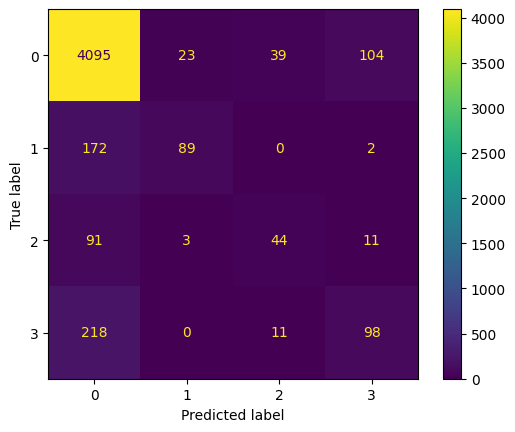

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(valConvertedLabels, preds)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()

# What happens if we combine the two methods?

Regenerating our datasets

In [52]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

# Flattening the datasets
flatTrainTokens = [item for sublist in train_dataset["tokens"] for item in sublist]
flatTrainLabels = [item for sublist in train_dataset["ner_tags"] for item in sublist]

flat_inputs_val = [item for sublist in val_dataset["tokens"] for item in sublist]
flat_labels_val = [item for sublist in val_dataset["ner_tags"] for item in sublist]

In [53]:
import random

random.seed(27)

# Function to undersample a dataset in the form of two seperate flattened 1D arrays
def undersampleFlatDataset(tokenList, tagList, undersampleClass, probability):
  newTokens = []
  newTags = []

  # Iterate through each token and tag
  for token, tag in zip(tokenList, tagList):
    # We do a dice roll if we hit a class that we want to undersample
    if tag == undersampleClass:
      # If the dice roll is less than our defined probability then we add it to the list
      if random.random() < probability:
        newTokens.append(token)
        newTags.append(tag)
    # We just add it back to the list if it is not a undersample class
    else:
      newTokens.append(token)
      newTags.append(tag)

  return newTokens, newTags


# In theory we can at maximum only double our minority classes, but we can re-run the function
def oversampleFlatDataset(tokenList, tagList, oversampleClass, probability, epochs = 1):
  newTokens = []
  newTags = []

  for epoch in range(epochs):
    # Iterate through the tags and tokens
    for token, tag in zip(tokenList, tagList):

      if tag == oversampleClass:
        # Dice roll to see if we duplicate the item
        if random.random() < probability:
          # We duplicate the tokens and the tags
          newTokens.append(token)
          newTokens.append(token)

          newTags.append(tag)
          newTags.append(tag)

      # If its not the target class we add it back normally
      else:
        newTokens.append(token)
        newTags.append(tag)

  return newTokens, newTags

Undersampling and oversampling the dataset

In [54]:
underTokens, underTags = undersampleFlatDataset(flatTrainTokens, flatTrainLabels, 'B-O', 0.3)

resampledTokens, resampledTags = oversampleFlatDataset(underTokens, underTags, 'B-LF', 0.4)
resampledTokens, resampledTags = oversampleFlatDataset(resampledTokens, resampledTags, 'B-AC', 0.4)
resampledTokens, resampledTags = oversampleFlatDataset(resampledTokens, resampledTags, 'I-LF', 0.4)

In [55]:
data2count = resampledTags

BOCount = data2count.count('B-O')
BLFCount = data2count.count('B-LF')
BACCount = data2count.count('B-AC')
ILFCount = data2count.count('I-LF')

print(f'Amount of B-O: {BOCount}')
print(f'Amount of B-LF: {BLFCount}')
print(f'Amount of B-AC: {BACCount}')
print(f'Amount of I-LF: {ILFCount}')

Amount of B-O: 9681
Amount of B-LF: 1158
Amount of B-AC: 1924
Amount of I-LF: 2620


Converting the undersampled datasets to lowercase

In [20]:
# lowerUnderTrainTokens = [item.lower() for item in underTokens]
# # lowerValTokens = [item.lower() for item in flat_inputs_val]
# # lowerValTokens = [item.lower() for item in underValTokens]

# print(len(lowerUnderTrainTokens))
# # print(len(lowerValTokens))

16710


Embedding the tokens

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

trainInputs = tfidf.fit_transform(resampledTokens)
valInputs = tfidf.transform(flat_inputs_val)

# Confirm both sets of inputs are of the same dimension
print(trainInputs.shape)
print(valInputs.shape)

(15383, 3958)
(5000, 3958)


Converting the labels to numeric

In [57]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

trainConvertedLabels = []
for sample in resampledTags:
    trainConvertedLabels.append(label_encoding.get(sample))

print(len(trainConvertedLabels))

valConvertedLabels = []
for sample in flat_labels_val:
    valConvertedLabels.append(label_encoding.get(sample))

print(len(valConvertedLabels))

15383
5000


In [58]:
from sklearn import svm

svmModel = svm.LinearSVC()

svmModel.fit(trainInputs, trainConvertedLabels)

from sklearn.metrics import classification_report

preds = svmModel.predict(valInputs)

print(classification_report(valConvertedLabels, preds))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4261
           1       0.70      0.28      0.40       263
           2       0.33      0.26      0.29       149
           3       0.35      0.33      0.34       327

    accuracy                           0.84      5000
   macro avg       0.57      0.45      0.49      5000
weighted avg       0.83      0.84      0.83      5000



We see that oversampling causes the most harm to training the SVM while undersampling does provide a decent boost to the minority scores.

[[3985   29   61  186]
 [ 187   74    1    1]
 [  92    3   39   15]
 [ 201    0   18  108]]


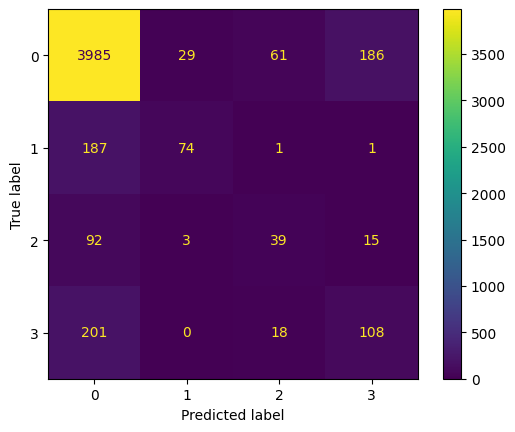

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(valConvertedLabels, preds)

print(cm)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

cmdisp.plot()